In [12]:
%pylab inline
import pandas as pd
import numpy as np
import sklearn.linear_model as linear
import sklearn.model_selection as selection
import sklearn.metrics as metrics
import sklearn.datasets as datasets

import torch as th
import torch.nn as nn
import torch.optim as optim

import scipy.stats as stats

from sklearn import preprocessing

Populating the interactive namespace from numpy and matplotlib


In [13]:
X = []
Y = []

#read file in
X = pd.read_csv("wdbc.data",header = 0)

#change diagnosis to binary
X[X.columns[1]] = X[X.columns[1]].map({'M':1,'B':0})

# assign diagnosis to Y
Y = X[X.columns[1]].values

#drop id and diagnosis columns
X = X.drop(X.columns[0], axis=1)
X = X.drop(X.columns[0], axis=1).values
X = preprocessing.normalize(X)

print(type(X), X.shape)
print(type(Y), Y.shape)

<class 'numpy.ndarray'> (568, 30)
<class 'numpy.ndarray'> (568,)


In [14]:
class MoonModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_func = nn.BCELoss()
        
    def forward(self, X):
        return None 
    
    def loss(self, X, y):
        probs = self.forward(X)
        return self.loss_func(probs, y)
    
    def predict_proba(self, X, as_numpy=False):
        res = self.forward(X)
        if as_numpy:
            res = res.detach().numpy()
        return res
    
    def predict(self, X, threshold=0.5, as_numpy=False):
        probs = self.predict_proba(X, as_numpy)
        return probs > threshold
    
    def fit(self, X, y, epochs=1000, lr=0.1, lam=0):
        optimizer = optim.RMSprop(self.parameters(), lr=lr)
        loss_curve = []
        for _ in range(epochs):
            optimizer.zero_grad()
            loss_val = self.loss(X, y) + self.regularize(lam)
            loss_curve.append(loss_val.data.item())
            loss_val.backward()
            optimizer.step()
        return loss_curve
    
    def regularize(self, lam):
        loss_val = 0
        for p in self.parameters():
            loss_val += lam * th.norm(p)
        return loss_val

In [15]:
class NNModel(MoonModel):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(30, 454, bias=True)
        self.act1 = nn.Sigmoid()
        self.l2 = nn.Linear(454, 1, bias=True)
        self.act2 = nn.Sigmoid()
        
    
    def forward(self, X):
        res = self.l1(X)
        res = self.act1(res)
        res = self.l2(res)
        res = self.act2(res)
        return res
    
    

C:\Users\raean\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


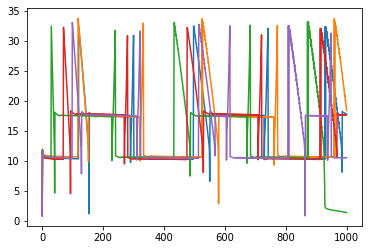

In [16]:
kf = selection.KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)

f1_nn1 = []

def plot_loss(loss_curve):
    plt.plot(list(range(len(loss_curve))), loss_curve)


for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    X_train = th.tensor(X_train, dtype=th.float32)
    X_test = th.tensor(X_test, dtype=th.float32)
    y_train = th.tensor(y_train, dtype=th.float32).view(-1, 1)
    y_test = th.tensor(y_test, dtype=th.float32).view(-1, 1)
    
    nn1 = NNModel()
    curve = nn1.fit(X_train, y_train, lam=0.01)
    plot_loss(curve)
    predictions = nn1.predict(X_test, as_numpy=True)
    probs = nn1.predict_proba(X_test, as_numpy=True)
    f1_nn1.append(metrics.f1_score(y_test, predictions))

In [17]:
print('MEAN FOR NN', np.mean(f1_nn1))
print('STD DEV FOR NN', np.std(f1_nn1))

MEAN FOR NN 0.22531645569620254
STD DEV FOR NN 0.27598420404884344


In [18]:
# KFOLD WITH CROSS VALIDATION WHERE K=5
kf = selection.KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)
f1s = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    lr = linear.LogisticRegression(solver='lbfgs')
    lr.fit(X_train, Y_train)
    predictions = lr.predict(X_test)
    probs = lr.predict_proba(X_test)[:,1]
    f1s.append(metrics.f1_score(Y_test, predictions))

print('THE MEAN F1 SCORE: ', np.mean(f1s), '\nSTD DEV F1 SCORE: ', np.std(f1s))


THE MEAN F1 SCORE:  0.5725982105069981 
STD DEV F1 SCORE:  0.10216187815133687


In [19]:
# T-TEST TO EVALUATE PERFORMANCE
print(stats.ttest_rel(f1s, f1_nn1))

Ttest_relResult(statistic=2.5320203228686005, pvalue=0.06452584641354643)


# REPORT

We can compare the means and standard deviations of the relevant f1 scores for each model.

A lower std dev on the f1 scores should indicate that the data had a low variance

In [20]:
# X_transformed = th.tensor(X, dtype=th.float32) 
# representations = nn1.forward(X_transformed)
# representations = representations.detach().numpy() 
# plt.scatter(representations[:,0], representations[:,1], c=colors) # plot representations of data in new space

In [21]:
# X, Y = datasets.make_moons(n_samples=1000, noise=0.15, shuffle=True)
# colors = np.array(['red' if cl == 0 else 'blue' for cl in Y])
# plt.scatter(X[:,0], X[:,1],c=colors)